# Summary

This notebook performs exploratory analysis to reveal the distributions and properties of the target variable for multiple forecast horizons.

# Imports and configuration

In [2]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# joinly analyze multiple target variables (different forecast horizons)
TARGET_VAR_LIST = [
    'discrete_return_30d', # 30-day
    'discrete_return_90d', # 90-day
    'discrete_return_365d' # 365-day
]

INPUT_PATH = r"C:\Users\mushj\Downloads\CURATED FINANCE DATA\FMP"

In [5]:
dfs = {}
for var in TARGET_VAR_LIST:
    df = pd.read_csv(INPUT_PATH + f'/{var}/combined/combined.csv')
    dfs[var] = df
    print("Loaded", var, df.shape)

Loaded discrete_return_30d (848888, 13)
Loaded discrete_return_90d (841063, 13)
Loaded discrete_return_365d (801944, 13)


In [9]:
# get price growth intervals
intervals = list(df.columns[3:])
for i in intervals:
    print(i)

(-inf, -0.15)
(-0.15, -0.077)
(-0.077, -0.039)
(-0.039, -0.02)
(-0.02, 0)
(0, 0.02)
(0.02, 0.039)
(0.039, 0.077)
(0.077, 0.15)
(0.15, inf)


In [21]:
# load daily closing prices dataset
daily_df = pd.read_csv(r"C:\Users\mushj\Downloads\PROCESSED FINANCE DATA\FMP\FMP_daily_prices_top1k.csv")
daily_df['date'] = pd.to_datetime(daily_df['date'], format='%Y-%m-%d')

# Summary

The table below shows the proportion of 'positive class' of each label in entire dataset.

## Treating levels as independent
* proportions are increasing in forecast horizon, i.e. the longer the horizon, the likelier to observe the various growths from the current week
* the distribution within each horizon holds: more extreme growths are less likely

In [12]:
prop_df = pd.concat([df[intervals].mean() for var,df in dfs.items()], axis=1)
prop_df.columns = TARGET_VAR_LIST
prop_df

,discrete_return_30d,discrete_return_90d,discrete_return_365d
"(-inf, -0.15)",0.061925,0.199754,0.444272
"(-0.15, -0.077)",0.225208,0.441163,0.655153
"(-0.077, -0.039)",0.482011,0.667136,0.806573
"(-0.039, -0.02)",0.675147,0.799027,0.884854
"(-0.02, 0)",1.000000,1.000000,1.000000
"(0, 0.02)",0.908924,0.949067,0.973281
"(0.02, 0.039)",0.701833,0.848443,0.934461
"(0.039, 0.077)",0.536944,0.767573,0.909676
"(0.077, 0.15)",0.270811,0.572536,0.830755
"(0.15, inf)",0.083366,0.297520,0.674853


## Finding proportions of labels jointly

In [39]:
prop_df2 = pd.concat([
    df.groupby(intervals+['labels']).size() / df.shape[0] for var,df in dfs.items()
], axis=1)
prop_df2.columns = TARGET_VAR_LIST
prop_df2 = prop_df2.reset_index()

In [44]:
# single level scenario
prop_df2[prop_df2[intervals].sum(axis=1) == 1]

,"(-inf, -0.15)","(-0.15, -0.077)","(-0.077, -0.039)","(-0.039, -0.02)","(-0.02, 0)","(0, 0.02)","(0.02, 0.039)","(0.039, 0.077)","(0.077, 0.15)","(0.15, inf)",labels,discrete_return_30d,discrete_return_90d,discrete_return_365d
0,0,0,0,0,1,0,0,0,0,0,[0 0 0 0 1 0 0 0 0 0],0.000131,0.000008,NaN


In [45]:
# full-label scenario: high variance (uncertainty)
prop_df2[prop_df2[intervals].sum(axis=1) == 10]

,"(-inf, -0.15)","(-0.15, -0.077)","(-0.077, -0.039)","(-0.039, -0.02)","(-0.02, 0)","(0, 0.02)","(0.02, 0.039)","(0.039, 0.077)","(0.077, 0.15)","(0.15, inf)",labels,discrete_return_30d,discrete_return_90d,discrete_return_365d
500,1,1,1,1,1,1,1,1,1,1,[1 1 1 1 1 1 1 1 1 1],0.000602,0.016057,0.182044


In [51]:
# negative-growth only
prop_df2[
    (prop_df2[intervals[5]] == 0) 
    & (prop_df2[intervals[6]] == 0) 
    & (prop_df2[intervals[7]] == 0)
    & (prop_df2[intervals[8]] == 0) 
    & (prop_df2[intervals[9]] == 0)
][TARGET_VAR_LIST].sum()

discrete_return_30d     0.037788
discrete_return_90d     0.017091
discrete_return_365d    0.006554
dtype: float64

In [49]:
# BEST CASE SCENARIO: positive-growth only (no negative-growth labels)
prop_df2[
    (prop_df2[intervals[0]] == 0) 
    & (prop_df2[intervals[1]] == 0) 
    & (prop_df2[intervals[2]] == 0)
    & (prop_df2[intervals[3]] == 0) 
    & (prop_df2[intervals[4]] == 0)
]

,"(-inf, -0.15)","(-0.15, -0.077)","(-0.077, -0.039)","(-0.039, -0.02)","(-0.02, 0)","(0, 0.02)","(0.02, 0.039)","(0.039, 0.077)","(0.077, 0.15)","(0.15, inf)",labels,discrete_return_30d,discrete_return_90d,discrete_return_365d


In [63]:
# DESIRABLE SCENARIOS: at least 1 positive-growth label, allowing one negative growth label=(-2% to 0%)
# i.e. 'safe downside', 'good upside'
prop_df2[
    (prop_df2[intervals[0]] == 0) 
    & (prop_df2[intervals[1]] == 0) 
    & (prop_df2[intervals[2]] == 0)
    & (prop_df2[intervals[3]] == 0) 
    & (prop_df2[intervals[4]] == 1)
    & (prop_df2[intervals[5:]].sum(axis=1) >= 1)
][TARGET_VAR_LIST].sum()

discrete_return_30d     0.262635
discrete_return_90d     0.158150
discrete_return_365d    0.090375
dtype: float64

## Top labels by horizon

In [71]:
for var in TARGET_VAR_LIST:
    view = (
        prop_df2[[var, 'labels']]
        .sort_values(var, ascending=False)
        .head(10)
    )
    display(view)
    print("Total proportion:", view[var].sum())

,discrete_return_30d,labels
28,0.092210,[0 0 0 0 1 1 1 1 0 0]
112,0.071495,[0 0 1 1 1 1 0 0 0 0]
60,0.069430,[0 0 0 1 1 1 1 1 0 0]
30,0.065038,[0 0 0 0 1 1 1 1 1 0]
120,0.056783,[0 0 1 1 1 1 1 0 0 0]
56,0.055179,[0 0 0 1 1 1 1 0 0 0]
124,0.052644,[0 0 1 1 1 1 1 1 0 0]
24,0.045336,[0 0 0 0 1 1 1 0 0 0]
238,0.042944,[0 1 1 1 1 1 0 0 0 0]
48,0.042769,[0 0 0 1 1 1 0 0 0 0]


Total proportion: 0.5938274542695856


,discrete_return_90d,labels
31,0.067953,[0 0 0 0 1 1 1 1 1 1]
126,0.067467,[0 0 1 1 1 1 1 1 1 0]
62,0.058403,[0 0 0 1 1 1 1 1 1 0]
30,0.056662,[0 0 0 0 1 1 1 1 1 0]
250,0.055619,[0 1 1 1 1 1 1 1 0 0]
127,0.053724,[0 0 1 1 1 1 1 1 1 1]
124,0.052820,[0 0 1 1 1 1 1 1 0 0]
63,0.052775,[0 0 0 1 1 1 1 1 1 1]
252,0.049641,[0 1 1 1 1 1 1 1 1 0]
246,0.039417,[0 1 1 1 1 1 1 0 0 0]


Total proportion: 0.554480461035618


,discrete_return_365d,labels
500,0.182044,[1 1 1 1 1 1 1 1 1 1]
253,0.145732,[0 1 1 1 1 1 1 1 1 1]
127,0.125744,[0 0 1 1 1 1 1 1 1 1]
499,0.095417,[1 1 1 1 1 1 1 1 1 0]
63,0.083301,[0 0 0 1 1 1 1 1 1 1]
31,0.078813,[0 0 0 0 1 1 1 1 1 1]
497,0.064319,[1 1 1 1 1 1 1 1 0 0]
252,0.038666,[0 1 1 1 1 1 1 1 1 0]
493,0.034514,[1 1 1 1 1 1 1 0 0 0]
485,0.029123,[1 1 1 1 1 1 0 0 0 0]


Total proportion: 0.8776735033867702


## Positively-skewed labels

In [73]:
prop_df3 = prop_df2.copy()

# assign weights -5, -4, -3, ..., 3, 4, 5 to the levels in order
weight = -5
for label in intervals:
    prop_df3[label] *= weight
    weight += 1

In [78]:
prop_df3['weighted_sum'] = prop_df3[intervals].sum(axis=1)

In [86]:
prop_df3.query('weighted_sum > 0')[TARGET_VAR_LIST].sum()

discrete_return_30d     0.293099
discrete_return_90d     0.364603
discrete_return_365d    0.331406
dtype: float64

In [84]:
prop_df3.query('weighted_sum > 6')

,"(-inf, -0.15)","(-0.15, -0.077)","(-0.077, -0.039)","(-0.039, -0.02)","(-0.02, 0)","(0, 0.02)","(0.02, 0.039)","(0.039, 0.077)","(0.077, 0.15)","(0.15, inf)",labels,discrete_return_30d,discrete_return_90d,discrete_return_365d,weighted_sum
7,0,0,0,0,-1,0,0,2,3,4,[0 0 0 0 1 0 0 1 1 1],0.001792,0.001379,0.001039,8
11,0,0,0,0,-1,0,1,0,3,4,[0 0 0 0 1 0 1 0 1 1],0.000270,0.000176,0.000128,7
15,0,0,0,0,-1,0,1,2,3,4,[0 0 0 0 1 0 1 1 1 1],0.004177,0.004711,0.003268,9
23,0,0,0,0,-1,0,0,2,3,4,[0 0 0 0 1 1 0 1 1 1],0.003584,0.005032,0.003311,8
27,0,0,0,0,-1,0,1,0,3,4,[0 0 0 0 1 1 1 0 1 1],0.001591,0.001656,0.000946,7
31,0,0,0,0,-1,0,1,2,3,4,[0 0 0 0 1 1 1 1 1 1],0.017016,0.067953,0.078813,9
47,0,0,0,-2,-1,0,1,2,3,4,[0 0 0 1 1 0 1 1 1 1],0.001434,0.002556,0.001692,7
63,0,0,0,-2,-1,0,1,2,3,4,[0 0 0 1 1 1 1 1 1 1],0.008041,0.052775,0.083301,7


# Symbol-level summary

The tables below show the distribution of 'proportion of positive class' across stocks.
For example, stocks experienced price growths between an interval within a N-day forecast horizon from the weekly closing price is X% of the time, on average.

In [14]:
summaries = {}
for var, df in dfs.items():
    print(var)
    summary = df.groupby('symbol')[intervals].mean()
    summaries[var] = summary
    display(summary.describe())

discrete_return_30d


,"(-inf, -0.15)","(-0.15, -0.077)","(-0.077, -0.039)","(-0.039, -0.02)","(-0.02, 0)","(0, 0.02)","(0.02, 0.039)","(0.039, 0.077)","(0.077, 0.15)","(0.15, inf)"
count,978.000000,978.000000,978.000000,978.000000,978.0,978.000000,978.000000,978.000000,978.000000,978.000000
mean,0.072663,0.245938,0.501165,0.682071,1.0,0.902031,0.703510,0.550934,0.291605,0.097752
std,0.067072,0.123714,0.117906,0.052898,0.0,0.044996,0.039541,0.101291,0.129372,0.086271
min,0.001921,0.044188,0.199808,0.494717,1.0,0.487152,0.533937,0.266090,0.030740,0.000961
25%,0.028946,0.153917,0.415730,0.651258,1.0,0.887608,0.682037,0.483378,0.198847,0.036503
50%,0.050913,0.219981,0.497387,0.691671,1.0,0.912749,0.707973,0.552354,0.271854,0.072019
75%,0.091319,0.312394,0.584389,0.719500,1.0,0.930836,0.731592,0.626321,0.374107,0.126987
max,0.480392,0.725490,0.812500,0.815789,1.0,0.964457,0.796610,0.785714,0.696335,0.524510


discrete_return_90d


,"(-inf, -0.15)","(-0.15, -0.077)","(-0.077, -0.039)","(-0.039, -0.02)","(-0.02, 0)","(0, 0.02)","(0.02, 0.039)","(0.039, 0.077)","(0.077, 0.15)","(0.15, inf)"
count,978.000000,978.000000,978.000000,978.000000,978.0,978.000000,978.000000,978.000000,978.000000,978.000000
mean,0.220623,0.462805,0.681773,0.803648,1.0,0.944529,0.846776,0.772985,0.586879,0.320342
std,0.126323,0.132091,0.092965,0.039666,0.0,0.032534,0.029147,0.056540,0.108065,0.146553
min,0.028074,0.159729,0.437561,0.630769,1.0,0.544276,0.645788,0.569072,0.262343,0.016457
25%,0.128025,0.367861,0.615682,0.779284,1.0,0.936292,0.832516,0.738547,0.519845,0.212972
50%,0.191708,0.450797,0.684414,0.809293,1.0,0.952565,0.850920,0.777348,0.593081,0.306438
75%,0.284449,0.547707,0.745402,0.831559,1.0,0.964182,0.864472,0.813339,0.661181,0.414085
max,0.741784,0.866972,0.916129,0.926966,1.0,0.986447,0.923372,0.903427,0.855721,0.776923


discrete_return_365d


,"(-inf, -0.15)","(-0.15, -0.077)","(-0.077, -0.039)","(-0.039, -0.02)","(-0.02, 0)","(0, 0.02)","(0.02, 0.039)","(0.039, 0.077)","(0.077, 0.15)","(0.15, inf)"
count,978.000000,978.000000,978.000000,978.000000,978.0,978.000000,978.000000,978.000000,978.000000,978.000000
mean,0.470051,0.673853,0.817213,0.888080,1.0,0.970083,0.931864,0.909891,0.833846,0.683697
std,0.156603,0.117747,0.070535,0.032940,0.0,0.023813,0.026042,0.035671,0.066677,0.118572
min,0.112790,0.356495,0.587110,0.748307,1.0,0.582393,0.723476,0.725806,0.490291,0.201087
25%,0.360524,0.599292,0.770393,0.869084,1.0,0.963821,0.919242,0.890319,0.793807,0.610320
50%,0.459215,0.672709,0.821590,0.892246,1.0,0.975831,0.934662,0.912780,0.841893,0.692899
75%,0.566624,0.751259,0.866181,0.909228,1.0,0.983887,0.948640,0.933535,0.881951,0.769320
max,1.000000,1.000000,0.992248,0.983871,1.0,0.996979,0.992248,0.990385,0.990385,1.000000


# Select symbols

In [18]:
# example price growth distributions of stocks that frequently had >15% growth in the 365-day horizon
df = summaries['discrete_return_365d']
df[df['(0.15, inf)'] >= 0.9]

,"(-inf, -0.15)","(-0.15, -0.077)","(-0.077, -0.039)","(-0.039, -0.02)","(-0.02, 0)","(0, 0.02)","(0.02, 0.039)","(0.039, 0.077)","(0.077, 0.15)","(0.15, inf)"
symbol,,,,,,,,,,
CEG,0.174757,0.456311,0.699029,0.815534,1.0,0.961165,0.873786,0.932039,0.961165,1.000000
CVNA,0.751429,0.865714,0.897143,0.842857,1.0,0.865714,0.851429,0.914286,0.911429,0.902857
HUBS,0.480331,0.710145,0.828157,0.888199,1.0,0.960663,0.948240,0.977226,0.964803,0.910973
KNSL,0.203085,0.457584,0.712082,0.822622,1.0,0.976864,0.971722,0.961440,0.976864,0.979434
MDB,0.596923,0.781538,0.892308,0.895385,1.0,0.932308,0.923077,0.963077,0.966154,0.938462
MEDP,0.428941,0.627907,0.806202,0.857881,1.0,0.981912,0.963824,0.971576,0.953488,0.935401
NET,0.588496,0.840708,0.871681,0.853982,1.0,0.911504,0.924779,0.960177,0.951327,0.911504
ROIV,0.714286,0.869565,0.900621,0.881988,1.0,0.931677,0.813665,0.962733,0.950311,0.931677
TEAM,0.426540,0.661137,0.803318,0.879147,1.0,0.964455,0.940758,0.966825,0.957346,0.905213


In [22]:
# select symbol to analyze
symbol = 'CEG'

symbol_df = dfs['discrete_return_365d'].query("symbol == @symbol")
plot_df = daily_df.query("symbol == @symbol")

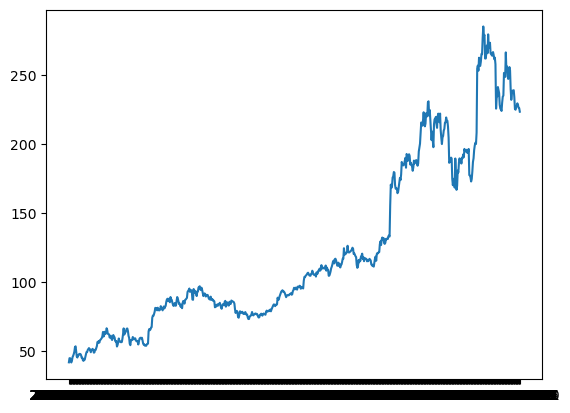

In [27]:
plt.plot(plot_df['date'], plot_df['close'])
# add graphics:
# label point of last actual data